# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder day after tomorrows close som target   

In [ ]:
import sklearn
import xgboost as xgb
from pytrends.request import TrendReq
import pytrends
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import streamlit as st
import google

In [ ]:
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__))
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')


In [ ]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [ ]:
# fill up a dataframe with all dates from 2015 up to today
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## get Google Trends Crypto data


In [ ]:
# get google trends data
from pytrends.request import TrendReq

pytrends = TrendReq()
df_trend = get_all_dates()
for ticker_name in ticker_names:
    print(ticker_name)
    pytrends.build_payload(kw_list=[ticker_name], cat=7, timeframe='all')
    df_temp = pytrends.interest_over_time()
    df_temp = df_temp.drop(columns=['isPartial'])
    df_temp.plot()
    df_trend = df_trend.merge(df_temp, how='left', left_index=True, right_index=True)
    df_trend[ticker_name] = df_trend[ticker_name].fillna(method='ffill')/30
    df_trend[ticker_name+'_30'] = df_trend[ticker_name].rolling(30, 1).mean()
    df_trend[ticker_name+'_90'] = df_trend[ticker_name].rolling(90, 1).mean()
    df_trend[ticker_name+'_250'] = df_trend[ticker_name].rolling(250, 1).mean()
    
    
# gruppera kolumnerna per typ av data
df_trend = df_trend[ticker_names + [ticker_name+'_30' for ticker_name in ticker_names] + [ticker_name+'_90' for ticker_name in ticker_names] + [ticker_name+'_250' for ticker_name in ticker_names]]

df_trend.tail()


In [ ]:
df_trend.to_csv('google_trends.csv')


## skapa alla modellerna

In [ ]:
df_trend.query('index>"2017-01-01"').sample(6)


In [ ]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [ ]:
df_org= get_all(tickers)

In [ ]:
display(df_org.isna().sum())
df_org.shape

In [ ]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined



Backtest av modellerna

In [77]:
def backtest(data, target, model, predictors, gap=0, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        taregt (str): Name of the target column
        model: Tex RandomForestClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 180.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 60.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    all_predictions = []
    print('last date', (data.iloc[-1].name).date())
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[(i+gap):(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


def print_results(predictions, target):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Precision:\t{prec:.4f}")
    return prec


### Beräkna predictors

In [194]:
def new_features(df_, ticker, target, horizons=[2,5,60,250]):
    df = df_.copy()
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    
    new_predictors = []
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10)

    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]

        # edit_column = f"edit_{horizon}"
        # df[edit_column] = rolling_averages['edit_count']
        ## Den ovan ändras till min Google Trends och görs på annan plats
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]     #### OBS! Skilj trend_column från Google Trends

        new_predictors += [ratio_column, trend_column]

    df['day_of_month'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    new_predictors += ['stoch_k','day_of_month','day_of_week','month']
    # df = df.dropna()
    return df, new_predictors


In [195]:
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
pd.options.display.precision = 4      # default 6
# print(tickers[0])
# df, new_predictors = new_features(df_org, tickers[0], 'y1')
# df[new_predictors+['y1']]


### Vi använder XGBoost

Loop öve all tickers och skapa 2 modeller  
    En mot y1 och en mot y2  
    spara båda modellerna  
Totalt 2 modeller per ticker    

Modellens namn:  
    ticker[:3]_y1  
    ticker[:3]_y2

In [210]:
def add_google_trends(df_, df_trend, ticker, new_predictors):
    df = df_.copy()
    
    lookup = {'BTC-USD': 'Bitcoin', 'ETH-USD': 'Ethereum', 'BCH-USD': 'Bitcoin Cash', 'XRP-USD': 'Ripple', 'ZRX-USD': '0X'}
    ticker_namn = lookup[ticker]
    
    df[ticker_namn + '_goog30'] = df_trend[ticker_namn + '_30']
    new_predictors.append(ticker_namn + '_goog30')
    df[ticker_namn + '_goog90'] = df_trend[ticker_namn + '_90']
    new_predictors.append(ticker_namn + '_goog90')
    df[ticker_namn + '_goog250'] = df_trend[ticker_namn + '_250']
    new_predictors.append(ticker_namn + '_goog250')
    
    return df, new_predictors


##### Generate all models and save them #####
def generate_all_models(df_org, tickers, horizons=[2,5,30,60,250], remove=[]):
    xgb_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4}
    precision_list=[]
    
    for ticker in tickers:
        namn = ticker[:3]
        print(namn)
        target = 'y1'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, new_predictors = new_features(df_org, ticker, target, horizons=horizons)
        df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)
        
        if remove != []:
            for col in remove:
                new_predictors.remove(col)
        predictions_xgb = backtest(df, target, model, new_predictors, proba_val= 0.55, step=30)

        precision_list.append((namn+'1', print_results(predictions_xgb, target)))

        # display(pd.DataFrame(model.feature_importances_,columns=['importance'], index=new_predictors).sort_values(by='importance', ascending=False))
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = new_predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind='bar', title=namn+'1' , figsize=(10, 10)).get_figure())
        plt.show( )
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[new_predictors], train[target],
                eval_set=[(train[new_predictors], train[target]),
                        (test[new_predictors], test[target])],
                verbose=False)

        model.save_model(f'{namn}_{target}.json')


        target='y2'
        model = xgb.XGBClassifier(**xgb_params,  random_state=2022, n_jobs=-1)
        df, new_predictors = new_features(df_org, ticker, target, horizons=horizons)
        df, new_predictors = add_google_trends(df, df_trend, ticker, new_predictors)

        if remove != []:
            for col in remove:
                new_predictors.remove(col)
        predictions_xgb = backtest(df, target, model, new_predictors, proba_val=0.55, step=30)

        precision_list.append((namn+'2',print_results(predictions_xgb, target)))
        
        df_imp = pd.DataFrame(model.feature_importances_, columns = ['importance'], index = new_predictors).sort_values(by = 'importance', ascending = False)
        print(df_imp.plot(kind = 'bar', title=namn+'2', figsize = (10, 10)).get_figure())
        plt.show()
        
        # Learning
        test_index = int(df.shape[0] * 0.8)
        train = df.iloc[:test_index].copy()
        test = df.iloc[test_index:].copy()
        model = xgb.XGBClassifier(early_stopping_rounds=100, 
                                **xgb_params,  
                                random_state=2022, n_jobs=-1)
        model.fit(train[new_predictors], train[target],
                eval_set=[(train[new_predictors], train[target]),
                        (test[new_predictors], test[target])],
                verbose=False)

        model.save_model(f'{namn}_{target}.json')
        
    return precision_list,new_predictors


BTC
last date 2022-10-07
Fördelning av y1: 1 vs 0:
1    0.5416
0    0.4584
Name: y1, dtype: float64
y1  Predictions
1   0              1013
0   0               872
1   1               386
0   1               312
dtype: int64
Precision:	0.5530
Figure(720x720)


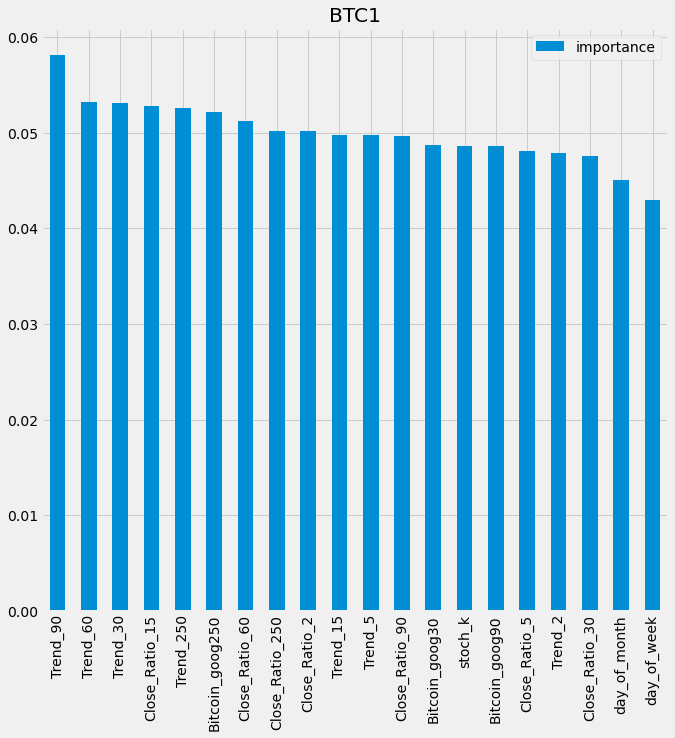

last date 2022-10-07
Fördelning av y2: 1 vs 0:
1    0.554
0    0.446
Name: y2, dtype: float64
y2  Predictions
1   0              984
0   0              794
1   1              447
0   1              358
dtype: int64
Precision:	0.5553
Figure(720x720)


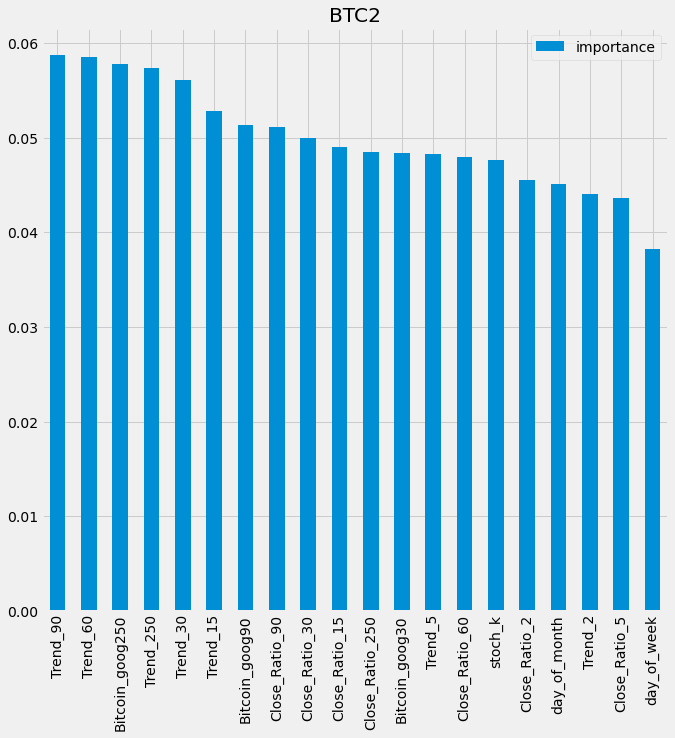

ETH
last date 2022-10-07
Fördelning av y1: 1 vs 0:
0    0.6434
1    0.3566
Name: y1, dtype: float64
y1  Predictions
0   0              1480
1   0               699
    1               222
0   1               182
dtype: int64
Precision:	0.5495
Figure(720x720)


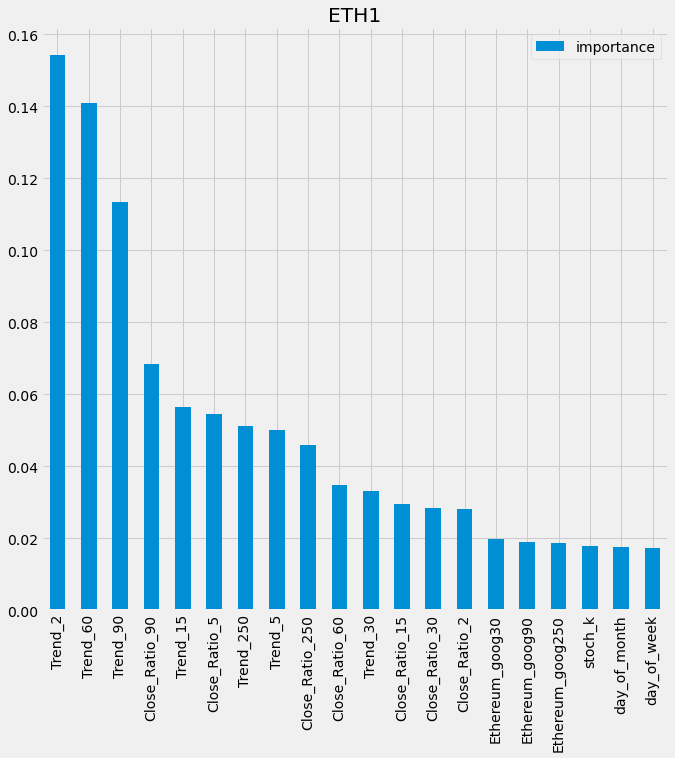

last date 2022-10-07
Fördelning av y2: 1 vs 0:
0    0.6427
1    0.3573
Name: y2, dtype: float64
y2  Predictions
0   0              1462
1   0               719
    1               204
0   1               198
dtype: int64
Precision:	0.5075
Figure(720x720)


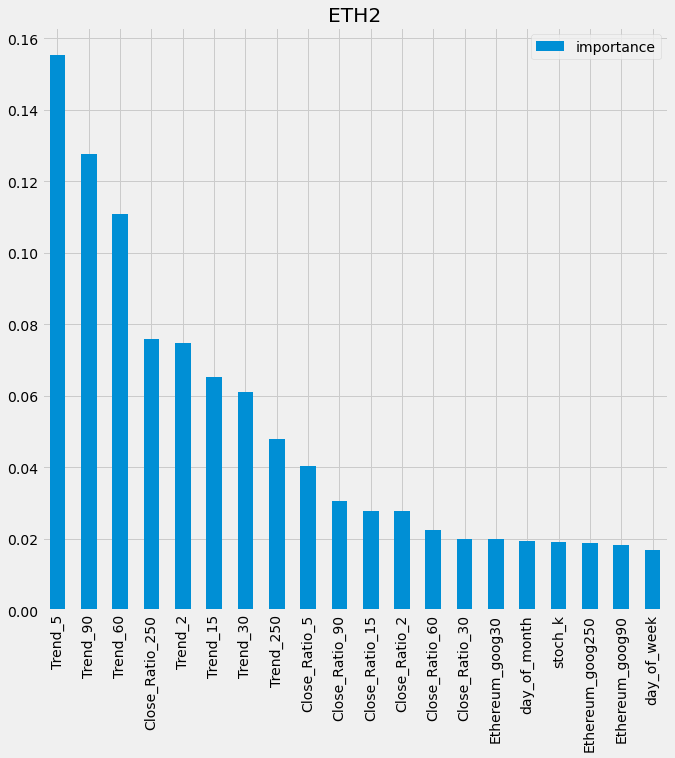

BCH
last date 2022-10-07
Fördelning av y1: 1 vs 0:
0    0.664
1    0.336
Name: y1, dtype: float64
y1  Predictions
0   0              1593
1   0               740
    1               128
0   1               122
dtype: int64
Precision:	0.5120
Figure(720x720)


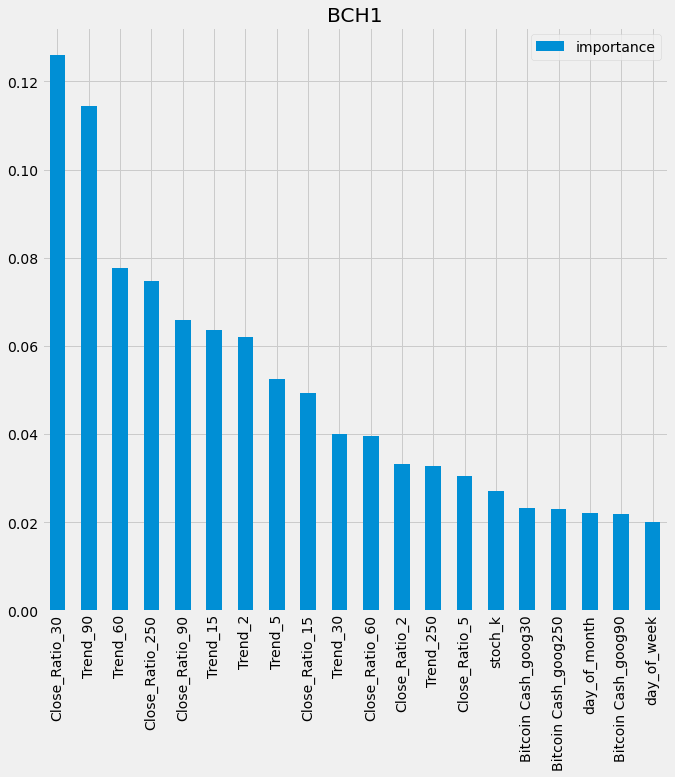

last date 2022-10-07
Fördelning av y2: 1 vs 0:
0    0.6698
1    0.3302
Name: y2, dtype: float64
y2  Predictions
0   0              1552
1   0               684
0   1               178
1   1               169
dtype: int64
Precision:	0.4870
Figure(720x720)


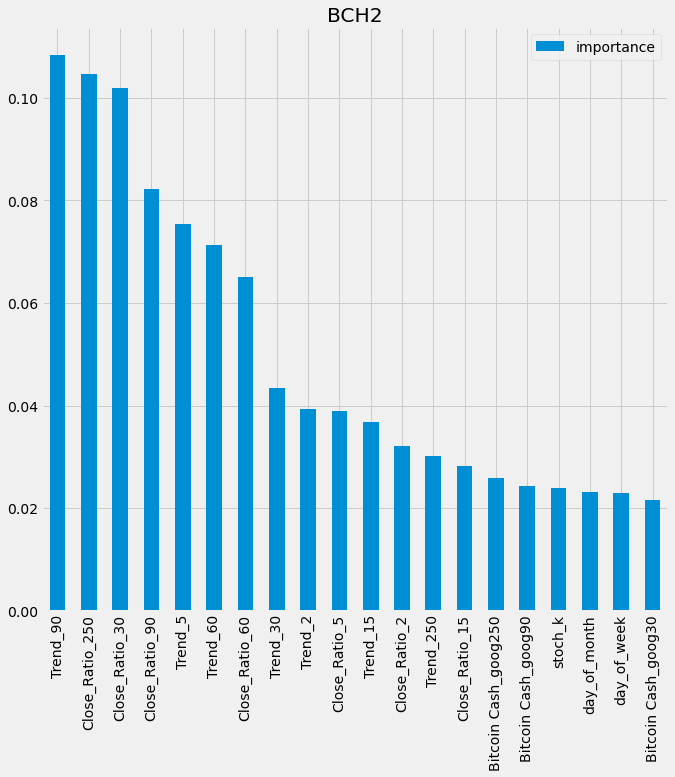

ZRX
last date 2022-10-07
Fördelning av y1: 1 vs 0:
0    0.6477
1    0.3523
Name: y1, dtype: float64
y1  Predictions
0   0              1579
1   0               789
    1               121
0   1                94
dtype: int64
Precision:	0.5628
Figure(720x720)


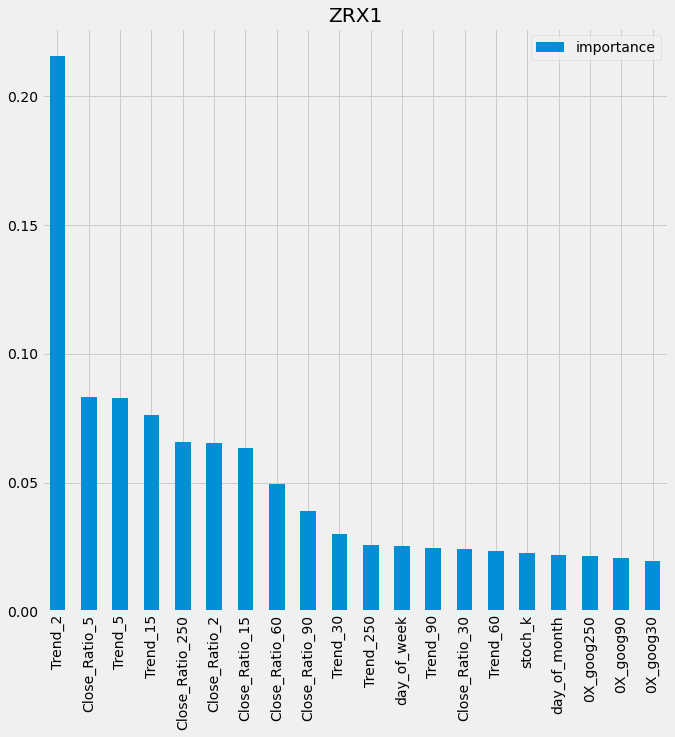

last date 2022-10-07
Fördelning av y2: 1 vs 0:
0    0.6547
1    0.3453
Name: y2, dtype: float64
y2  Predictions
0   0              1528
1   0               738
0   1               163
1   1               154
dtype: int64
Precision:	0.4858
Figure(720x720)


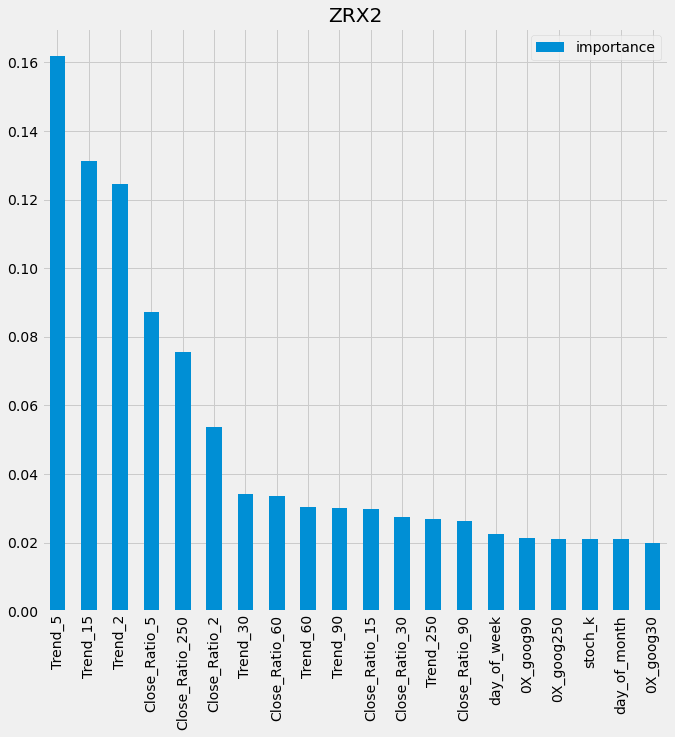

XRP
last date 2022-10-07
Fördelning av y1: 1 vs 0:
0    0.6585
1    0.3415
Name: y1, dtype: float64
y1  Predictions
0   0              1529
1   0               663
    1               219
0   1               172
dtype: int64
Precision:	0.5601
Figure(720x720)


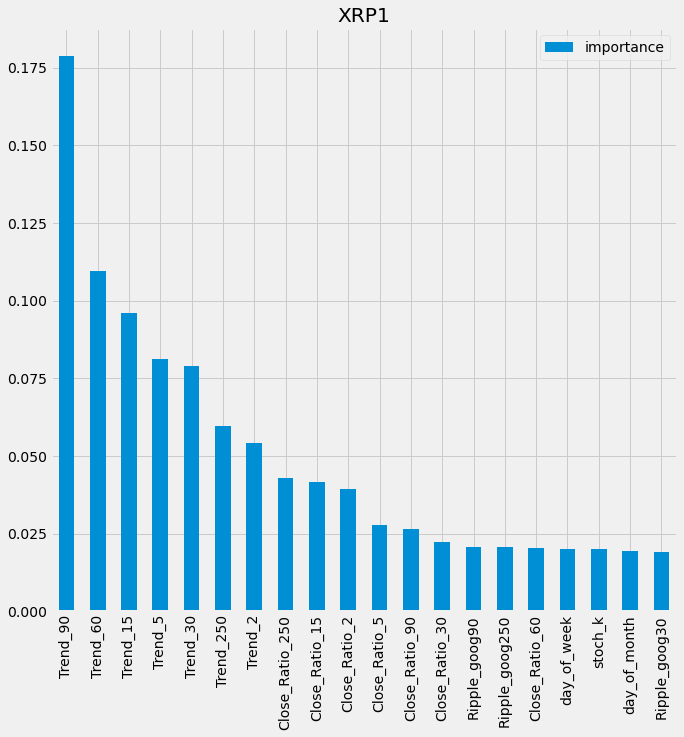

last date 2022-10-07
Fördelning av y2: 1 vs 0:
0    0.6709
1    0.3291
Name: y2, dtype: float64
y2  Predictions
0   0              1533
1   0               688
0   1               200
1   1               162
dtype: int64
Precision:	0.4475
Figure(720x720)


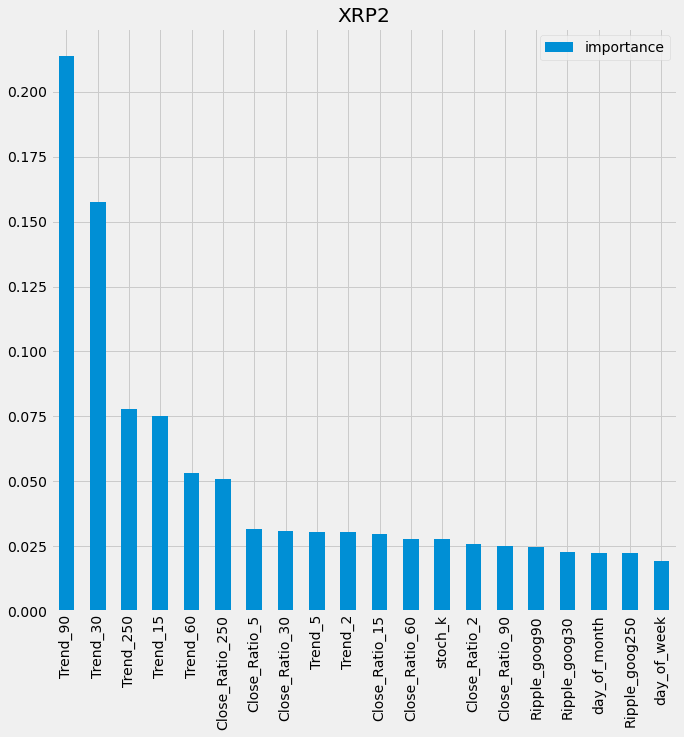

In [231]:
precision_list, new_predictors = generate_all_models(df_org, tickers, horizons=[2,5,15,30,60,90,250], remove=['month'])

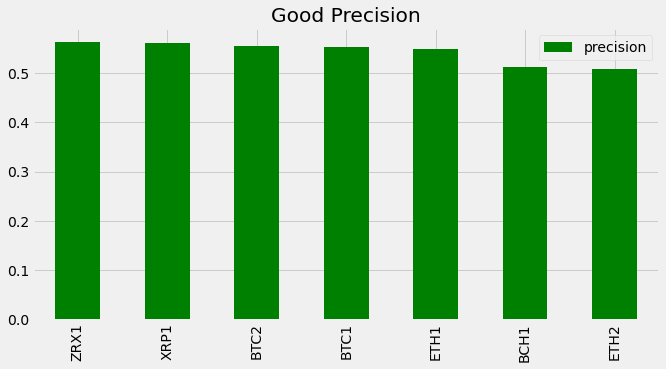

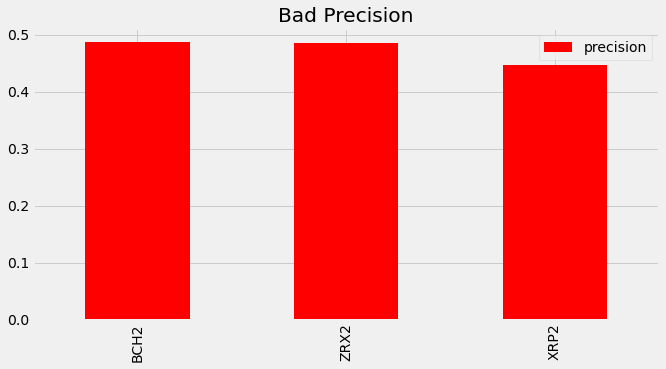

In [232]:
df_precision = pd.DataFrame(dict(precision_list), index=['precision']).T
# red color for negative values
df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title = 'Good Precision', color='green')
try:
    df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title='Bad Precision',color='red')
except:
    pass


df_precision.to_csv('precision_no_month_15_90.csv')

Kollar TimeSeriesSplit Cross Validation  
Jag gillar min egen backtest-variant bätte   
- Den har start vilket garanterar att första Train-datat inte är för litet  
- Den har step-size i stället för n_splits vilka ger samma index-värden om så önskas  
- Båda har gap 

In [228]:
horizons=[2,5,15,30,60,90,250]
df, new_predictors = new_features(df_org, tickers[0], 'y1', horizons=horizons)
df, new_predictors = add_google_trends(df, df_trend, tickers[0], new_predictors)

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap=1)
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index[0], '-', train_index[-1], "\nTEST:", test_index[0], '-', test_index[-1])
    # X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # y_train, y_test = df.iloc[train_index], df.iloc[test_index]


TRAIN: 0 - 271 
TEST: 273 - 539
TRAIN: 0 - 538 
TEST: 540 - 806
TRAIN: 0 - 805 
TEST: 807 - 1073
TRAIN: 0 - 1072 
TEST: 1074 - 1340
TRAIN: 0 - 1339 
TEST: 1341 - 1607
TRAIN: 0 - 1606 
TEST: 1608 - 1874
TRAIN: 0 - 1873 
TEST: 1875 - 2141
TRAIN: 0 - 2140 
TEST: 2142 - 2408
TRAIN: 0 - 2407 
TEST: 2409 - 2675
TRAIN: 0 - 2674 
TEST: 2676 - 2942


### Test plotly

In [85]:
# df[new_predictors].tail(5)

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,stoch_k,day_of_month,day_of_week,month
Date,,,,,,,,,,,,
2022-10-03,1.0150,19333.8438,1.0117,19396.9246,0.9391,20895.1272,0.6453,30409.7832,0.6590,3,0,10
2022-10-04,1.0178,19980.2119,1.0403,19549.6832,0.9756,20845.9194,0.6702,30342.5777,0.7718,4,1,10
2022-10-05,0.9957,20248.7803,1.0236,19695.4688,0.9693,20799.2434,0.6660,30272.0832,0.9468,5,2,10
2022-10-06,0.9949,20058.0801,1.0066,19824.1383,0.9619,20745.5692,0.6608,30199.3523,0.8321,6,3,10
2022-10-07,0.9862,19683.8594,0.9756,19897.7719,0.9390,20672.2824,0.6444,30125.3310,0.5723,7,4,10


In [ ]:
import plotly.express as px
# fig = px.line(df[new_predictors],title='crypto')
# fig.show()